# spectral gap実験の解析

現在使用しているインスタンスセットで、6~8 siteの$\beta=5$の結果について、一部上手くいっていない原因を調査する。

## import

In [277]:
import numpy as np
import scipy.linalg
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.colorbar as colorbars
import matplotlib.gridspec as gridspec
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import datetime
import os
import time
import pathlib
import sys
import uncertainties
import pickle
from uncertainties import ufloat

import made
from made import MADE
import mcmc_function as mcmc
import ising_model as ising
from ising_model import Ising_model
import QAOA_function as qaoa
from QAOA_function import QAOA_ansatz

plt.rcParams["font.family"] = "Helvetica"
plt.rcParams['mathtext.fontset'] = 'cm'

seed = None
random.seed(seed)
rng = np.random.default_rng(seed)
#generator = torch.Generator().manual_seed(seed)

## spectral gapの分布

### データのロード

In [278]:
beta = 5.0
n_spin = 6

gap_data = np.load("result/spectral_gap/{0}_sites/beta_{1}.npy".format(n_spin, '{:.0e}'.format(beta)))
print(gap_data.shape)

(5, 100)


### 描画

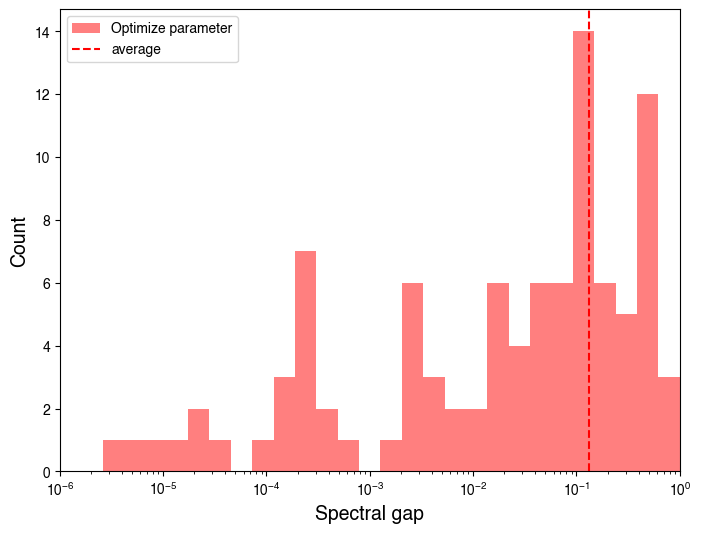

In [279]:
bins = np.logspace(-6, 0, num=30)

fig1, ax1 = plt.subplots(figsize=(8,6))
ax1.hist(gap_data[0], bins=bins, color='red', alpha=0.5, label='Optimize parameter')
ax1.axvline(np.average(gap_data[0]), linestyle='--', color='red', label='average')
ax1.set_xscale('log')
ax1.set_xlim(1e-6, 1)
ax1.set_xlabel("Spectral gap", {"fontsize": 14})
ax1.set_ylabel("Count", {"fontsize": 14})
ax1.legend()

In [280]:
gap_rank = np.sort(gap_data[0])
print(gap_rank[0:10])

gap_rank_id = np.argsort(gap_data[0])
print(gap_rank_id[0:10])
print(gap_rank_id[-10:-1])

[2.63474463e-08 3.50448935e-08 7.47810710e-08 3.49455715e-06
 4.58327418e-06 8.70534148e-06 1.44503815e-05 2.02013106e-05
 2.43641127e-05 3.09578074e-05]
[92  1 50 47 27 54 42 13 28 81]
[22 85  5 58 96 86 29 21 79]


## 結果の悪いインスタンスに対する詳細な調査

特にid=[92,1,50]が悪いので、詳細なデータを取得する。

### インスタンス取得

In [281]:
# import instance sets
source_dir_name = 'data/instance_set_2024-0614-1705-31'
fname_in = pathlib.Path(source_dir_name).joinpath('{0}_sites_instance_set.pickle'.format(n_spin))
with open(str(fname_in), 'rb') as f:
	instance_set = pickle.load(f)
instance = instance_set[79]

### QAOA最適化

Optimization terminated successfully.
         Current function value: -2.811555
         Iterations: 24
         Function evaluations: 297
         Gradient evaluations: 27
[7, 26, 24, 39, 42, 39, 39, 24, 56, 7, 24, 24, 24, 25, 24, 44, 24, 7, 24, 56]


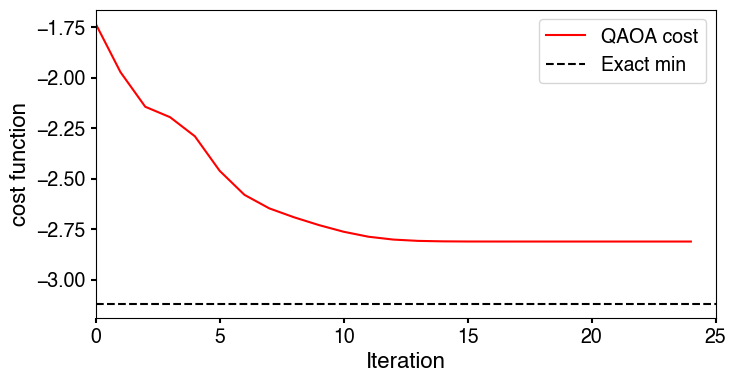

In [282]:
# setting
n_train = 2**n_spin
n_test = int(n_spin * 0.25)
n_samples = n_train + n_test

prob_hamiltonian = instance.get_hamiltonian()
mixer_hamiltonian = qaoa.generate_X_mixer(n_spin)
n_layers = 5
qaoa_ansatz = QAOA_ansatz(prob_hamiltonian, mixer_hamiltonian, n_layers)

def cost(para):
    return qaoa.cost_QAOA(prob_hamiltonian, qaoa_ansatz, para)

def callback(para):
    para_history.append(para)
    cost_history.append(cost(para))

# running QAOA
init_para = [0.2705, -0.5899, 0.4803, -0.4492, 0.5074, -0.3559, 0.5646, -0.2643, 0.6397, -0.1291] #文献におけるSKmodelに対するQAOA(p=5)の固定角
para_history = [init_para]
cost_history = [cost(init_para)]

method = "BFGS"
options = {"disp": True, "maxiter": 200, "gtol": 1e-6}
opt = scipy.optimize.minimize(cost, init_para, 
                              method=method,
                              callback=callback,
                              options=options)

opt_para = para_history[-1]

# sampling QAOA outputs
opt_qaoa_data_idx = qaoa.sampling_QAOA(qaoa_ansatz, para_history[-1], n_samples, rand_seed=seed) # optimize parameter
opt_qaoa_data_nd = np.array([qaoa.number_to_binary(opt_qaoa_data_idx[i], n_spin) for i in range(len(opt_qaoa_data_idx))], dtype='float32') # MADEモデルのコードが重み行列をfloat32で記述しているため、データもfloat32に明示的に指定する！

# plot
min_energy = ising.min_exact_spin_energy(instance)

fig2, ax2 = plt.subplots(figsize=(8,4), dpi=100)
ax2.plot(cost_history, color="red", label="QAOA cost")
ax2.hlines(y=min_energy, xmin=0, xmax=len(cost_history), color="black", linestyle="--", label="Exact min")
ax2.set_xlabel("Iteration", fontsize=16)
ax2.set_ylabel("cost function", fontsize=16)
ax2.set_xlim(0, len(cost_history))
ax2.tick_params(width=1.5, labelsize=14)
ax2.legend(fontsize=14)

print(opt_qaoa_data_idx[0:20])

### QAOA出力分布

[3.03277650e-05 3.03277650e-05 3.31486757e-05 3.31486757e-05
 4.45455216e-05 4.45455216e-05 5.57673612e-05 5.57673612e-05
 8.05565625e-05 8.05565625e-05]


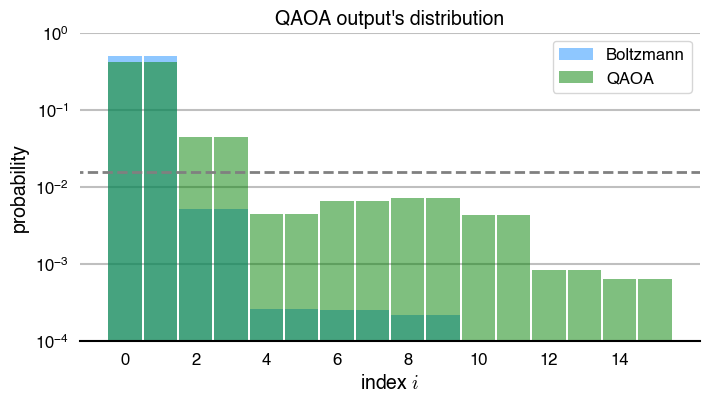

In [283]:
boltzmann_prob = ising.spin_boltzmann_distribution(instance, beta)
boltzmann_prob_sort = np.sort(boltzmann_prob)[::-1]
qaoa_output_dist = qaoa.distribution_QAOA(qaoa_ansatz, para_history[-1])

n_top = 16
sort_idx = np.argsort(boltzmann_prob)[::-1]

fig3, ax3 = plt.subplots(figsize=(8,4), dpi=100)

ax3.spines["top"].set_linewidth(0)
ax3.spines["left"].set_linewidth(0)
ax3.spines["bottom"].set_linewidth(1.5)
ax3.spines["right"].set_linewidth(0)

ax3.bar(np.arange(n_top), boltzmann_prob_sort[0:n_top], width=0.95, color='dodgerblue', alpha=0.5, label="Boltzmann")
ax3.bar(np.arange(n_top), qaoa_output_dist[sort_idx[0:n_top]], width=0.95, color='green', alpha=0.5, label="QAOA")
ax3.axhline(1/(2**n_spin), xmin=-0.5, xmax=15.5, linestyle='--', linewidth=2.0, color='grey')
ax3.grid(axis='y', color='#BFBFBF', linestyle='-', linewidth=1.5)
ax3.set_axisbelow(True) #gridを背面にする
ax3.set_xlabel(r'index $i$', fontsize=14)
ax3.set_ylabel("probability", fontsize=14)
ax3.set_xticks(np.arange(0, n_top, 2))
ax3.set_yscale('log')
ax3.set_ylim(1e-4, 1e0)
ax3.tick_params(width=0, labelsize=12, length=5)
ax3.tick_params(axis="y", which='minor', width=0.0)
ax3.set_title("QAOA output's distribution", fontsize=14)
ax3.legend(fontsize=12)

print(np.sort(qaoa_output_dist)[0:10])

### MADE学習

[3.3420351e-06 4.3606483e-06 5.0319054e-06 5.2457390e-06 5.4726820e-06
 6.4617789e-06 6.7363562e-06 1.0921450e-05 1.3626774e-05 1.4757090e-05]


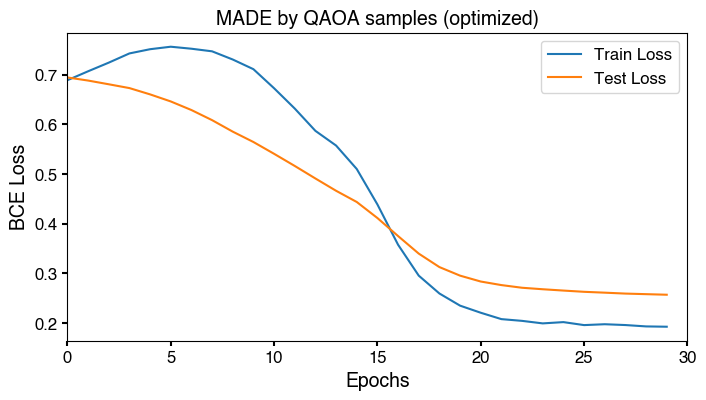

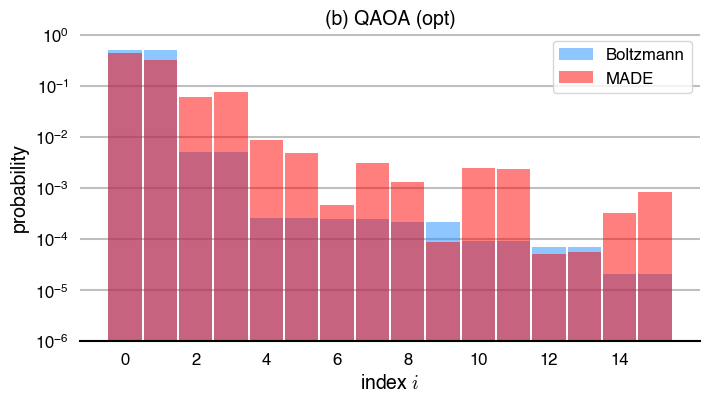

In [284]:
# learn MADE by QAOA samples
hidden_layers = 2
batchsize = 8
lr = 0.005
n_epochs = 30
hidden_size = 2 * n_spin
hidden_list = [hidden_size for i in range(hidden_layers)]

qaoa_opt_data = torch.from_numpy(opt_qaoa_data_nd).to(dtype=torch.float32)
qaoa_opt_traindata, qaoa_opt_testdata = torch.utils.data.random_split(dataset=qaoa_opt_data, lengths=[n_train, n_test], generator=generator)
qaoa_opt_testset = torch.utils.data.DataLoader(qaoa_opt_testdata, batch_size=batchsize, shuffle=False)
qaoa_opt_trainset = torch.utils.data.DataLoader(qaoa_opt_traindata, batch_size=batchsize, shuffle=True)

model_qaoa_opt = MADE(n_spin, hidden_list, n_spin, num_masks=1, natural_ordering=True)
opt_qaoa_opt = torch.optim.Adam(model_qaoa_opt.parameters(), lr=lr, weight_decay=1e-4)
scheduler_qaoa_opt = torch.optim.lr_scheduler.StepLR(opt_qaoa_opt, step_size=45, gamma=0.1)

test_loss, train_loss = made.run_train(model_qaoa_opt, qaoa_opt_trainset, qaoa_opt_testset, n_epochs, opt_qaoa_opt, scheduler_qaoa_opt, seed)

all_inputs = np.array([made.number_to_binary(i, n_spin) for i in range(2**n_spin)])
qaoa_opt_pred_dist = made.compute_log_prob(model_qaoa_opt, all_inputs)
qaoa_opt_pred_dist = np.exp(qaoa_opt_pred_dist)

fig5, ax5 = plt.subplots(figsize=(8,4), dpi=100)
ax5.plot(np.arange(n_epochs), train_loss, label='Train Loss')
ax5.plot(np.arange(n_epochs), test_loss, label='Test Loss')
ax5.set_xlabel("Epochs", fontsize=14)
ax5.set_ylabel("BCE Loss", fontsize=14)
ax5.tick_params(width=1.5, labelsize=12)
ax5.set_xlim(0, n_epochs)
ax5.set_title("MADE by QAOA samples (optimized)", fontsize=14)
ax5.legend(fontsize=12)

# plot
fig4, ax4 = plt.subplots(figsize=(8,4), dpi=100)

ax4.spines["top"].set_linewidth(0)
ax4.spines["left"].set_linewidth(0)
ax4.spines["bottom"].set_linewidth(1.5)
ax4.spines["right"].set_linewidth(0)

ax4.bar(np.arange(n_top), boltzmann_prob_sort[0:n_top], width=0.95, color='dodgerblue', alpha=0.5, label="Boltzmann")
ax4.bar(np.arange(n_top), qaoa_opt_pred_dist[sort_idx[0:n_top]], width=0.95, color='red', alpha=0.5, label="MADE")
ax4.grid(axis='y', color='#BFBFBF', linestyle='-', linewidth=1.5)
ax4.set_axisbelow(True) #gridを背面にする
ax4.set_xlabel(r'index $i$', fontsize=14)
ax4.set_ylabel("probability", fontsize=14)
ax4.set_xticks(np.arange(0, n_top, 2))
ax4.set_yscale('log')
ax4.set_ylim(1e-6, 1.1e0)
ax4.tick_params(width=0, labelsize=12, length=5)
ax4.tick_params(axis="y", which='minor', width=0.0)
ax4.set_title("(b) QAOA (opt)", fontsize=14)
ax4.legend(fontsize=12)

print(np.sort(qaoa_opt_pred_dist)[0:10])

### spectral gap計算(念のため)

In [285]:
# get proposal matrix
qaoa_opt_made_Q = np.zeros((2**n_spin, 2**n_spin))
for i in range(2**n_spin):
	for j in range(2**n_spin):
		qaoa_opt_made_Q[j,i] = qaoa_opt_pred_dist[j] # MADE(QAOA + opt)

# calculate spectral gap
energy = np.array([ising.spin_energy(ising.number_to_spin(i, n_spin), instance) for i in range(2**n_spin)])

# MADE(QAOA)
qaoa_opt_made_P = np.zeros((2**n_spin, 2**n_spin))
qaoa_opt_made_A = mcmc.calc_boltzmann_mh_acceptance(energy, qaoa_opt_made_Q, beta)
qaoa_opt_made_P = qaoa_opt_made_Q * qaoa_opt_made_A

np.fill_diagonal(qaoa_opt_made_P, 0)
for i in range(2**n_spin):
	qaoa_opt_made_P[i,i] = 1 - np.sum(qaoa_opt_made_P[:,i])
	
print(mcmc.spectral_gap(qaoa_opt_made_P))

0.39650038941590415


### MADE最適化によるばらつきの確認